In [1]:
#!python -m pip install -U pip
#!pip install -U setuptools setuptools_scm pep517
#!pip install -U emcee
#!pip install pygtc

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import emcee
from scipy.optimize import minimize
import pygtc

Inizializzo le variabili di interesse e definisco il parametro rho_m.

In [3]:
rho_m = 0.286 * 0.7**2 *2.7751428946e11
M = np.array([10**13.5, 10**14.0, 10**15.0])
c = np.array([2, 5, 10])
z = 0.
R = np.linspace(0.03,1.0,1000)
rho_m

38890852524.924385

Calcolo r_s sotto forma di matrice 3x3. Ogni entrata contiene il prodotto tra un diverso elemento di 1/c e del termine in radice cubica.

Nota: Le entrate della matrice sono:
    np.outer(a,b) = 
    ([[a1b1, a1b2, a1b3],
      [a2b1, a2b2, a2b3],
      [a3b1, a3b2, a3b3]])

In [4]:
r_s = np.outer(np.cbrt(3 * M / (4 * np.pi * 200 * rho_m * (1+z)**3)), 1/c)
r_s

array([[0.49504877, 0.19801951, 0.09900975],
       [0.72663221, 0.29065289, 0.14532644],
       [1.56548165, 0.62619266, 0.31309633]])

Calcolo rho_s.

In [5]:
f_c = np.log(1 + c) - c / (1 + c)
delta_char = 200 * c**3 / (3 * f_c)
rho_s = rho_m * (1+z)**3 * delta_char
rho_s

array([4.80194426e+13, 3.38148581e+14, 1.74148032e+15])

Infine calcolo f(x). x sarà un array 1000x3x3 in cui ogni entrata è funzione di un diverso valore di R,c ed M. Allo stesso modo f sarà una matrice delle stesse dimensioni in cui ogni entrata è la funzione f applicata alla corrispondente entrata di x.

In [6]:
x = np.multiply.outer(R, 1/r_s)
ones = np.ones((1000, 3, 3))

In [7]:
f = np.empty((1000, 3, 3))
for i in range(1000):
    for j in range(3):
        for k in range(3):
            if np.less(x, ones)[i, j, k]:
                f[i, j, k] = (1 - (2 * np.arctanh(np.sqrt((1-x[i, j, k])/(1+x[i, j, k]))) / np.sqrt(1 - x[i, j, k]**2))) / (x[i, j, k]**2 - 1)
            else: 
                if np.greater(x, ones)[i, j, k]:
                    f[i, j, k] = (1 - (2 * np.arctan(np.sqrt((x[i, j, k]-1)/(1+x[i, j, k]))) / np.sqrt(x[i, j, k]**2 - 1))) / (x[i, j, k]**2 - 1)
                else: 
                    f[i, j, k] = 1./3

Il risultato ottenuto è corretto, ma è poco efficiente questa implementazione, perché opera elemento per elemento su 9000 elementi diversi con 3 for innestati uno nell'altro. Posso piuttosto osservare che le funzioni che definiscono f negli intervalli x<1 e x>1 hanno domini disgiunti e utilizzare questo fatto a mio vantaggio.

In [8]:
f1 = (1 - (2 * np.arctanh(np.sqrt((1 - x) / (1 + x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
f2 = (1 - (2 * np.arctan(np.sqrt((x - 1) / (1 + x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)
f1[np.isnan(f1)] = 0
f2[np.isnan(f2)] = 0
f = f1 + f2
f = np.where(f == 0., 1./3, f)
f

C:\Users\Ghigu\AppData\Local\Temp\ipykernel_9348\704835143.py:1: RuntimeWarning: invalid value encountered in sqrt
  f1 = (1 - (2 * np.arctanh(np.sqrt((1 - x) / (1 + x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
C:\Users\Ghigu\AppData\Local\Temp\ipykernel_9348\704835143.py:2: RuntimeWarning: invalid value encountered in sqrt
  f2 = (1 - (2 * np.arctan(np.sqrt((x - 1) / (1 + x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)


array([[[2.51134577, 1.64228572, 1.05187222],
        [2.88817796, 1.99859943, 1.36815931],
        [3.65000087, 2.74161541, 2.06918868]],

       [[2.48027929, 1.61343523, 1.0270845 ],
        [2.85675277, 1.96850024, 1.34079687],
        [3.61826755, 2.71030554, 2.03890923]],

       [[2.45020997, 1.58560069, 1.00330256],
        [2.82631925, 1.93940911, 1.31445248],
        [3.58752024, 2.67998921, 2.00963616]],

       ...,

       [[0.1302552 , 0.02960447, 0.00848095],
        [0.22312385, 0.05669221, 0.01711937],
        [0.54876325, 0.1823138 , 0.0640137 ]],

       [[0.13006865, 0.02955446, 0.00846565],
        [0.22283572, 0.05660168, 0.01708944],
        [0.54822139, 0.1820681 , 0.06391279]],

       [[0.1298825 , 0.02950457, 0.00845038],
        [0.22254816, 0.05651137, 0.01705959],
        [0.54768038, 0.1818229 , 0.06381212]]])

In conclusione posso calcolare Sigma. Sarà una matrice 1000x3x3 in cui il primo indice scorre sugli R, il secondo scorre sugli M e il terzo scorre sui c.

In [9]:
Sigma = 2* rho_s * r_s * f
Sigma

array([[[1.19399251e+14, 2.19934952e+14, 3.62735057e+14],
        [2.01551349e+14, 3.92860137e+14, 6.92516110e+14],
        [5.48767092e+14, 1.16105307e+15, 2.25645480e+15]],

       [[1.17922229e+14, 2.16071294e+14, 3.54187085e+14],
        [1.99358343e+14, 3.86943608e+14, 6.78666167e+14],
        [5.43996079e+14, 1.14779358e+15, 2.22343499e+15]],

       [[1.16492615e+14, 2.12343692e+14, 3.45985949e+14],
        [1.97234542e+14, 3.81225231e+14, 6.65331526e+14],
        [5.39373310e+14, 1.13495485e+15, 2.19151264e+15]],

       ...,

       [[6.19284436e+12, 3.96463165e+12, 2.92463244e+12],
        [1.55706862e+13, 1.11438591e+13, 8.66525025e+12],
        [8.25049708e+13, 7.72084946e+13, 6.98070856e+13]],

       [[6.18397483e+12, 3.95793368e+12, 2.91935338e+12],
        [1.55505792e+13, 1.11260634e+13, 8.65009877e+12],
        [8.24235030e+13, 7.71044412e+13, 6.96970413e+13]],

       [[6.17512452e+12, 3.95125271e+12, 2.91408860e+12],
        [1.55305118e+13, 1.11083104e+13, 8.634987

Ho calcolato tutti i valori di Sigma di mio interesse e procedo a graficarli.

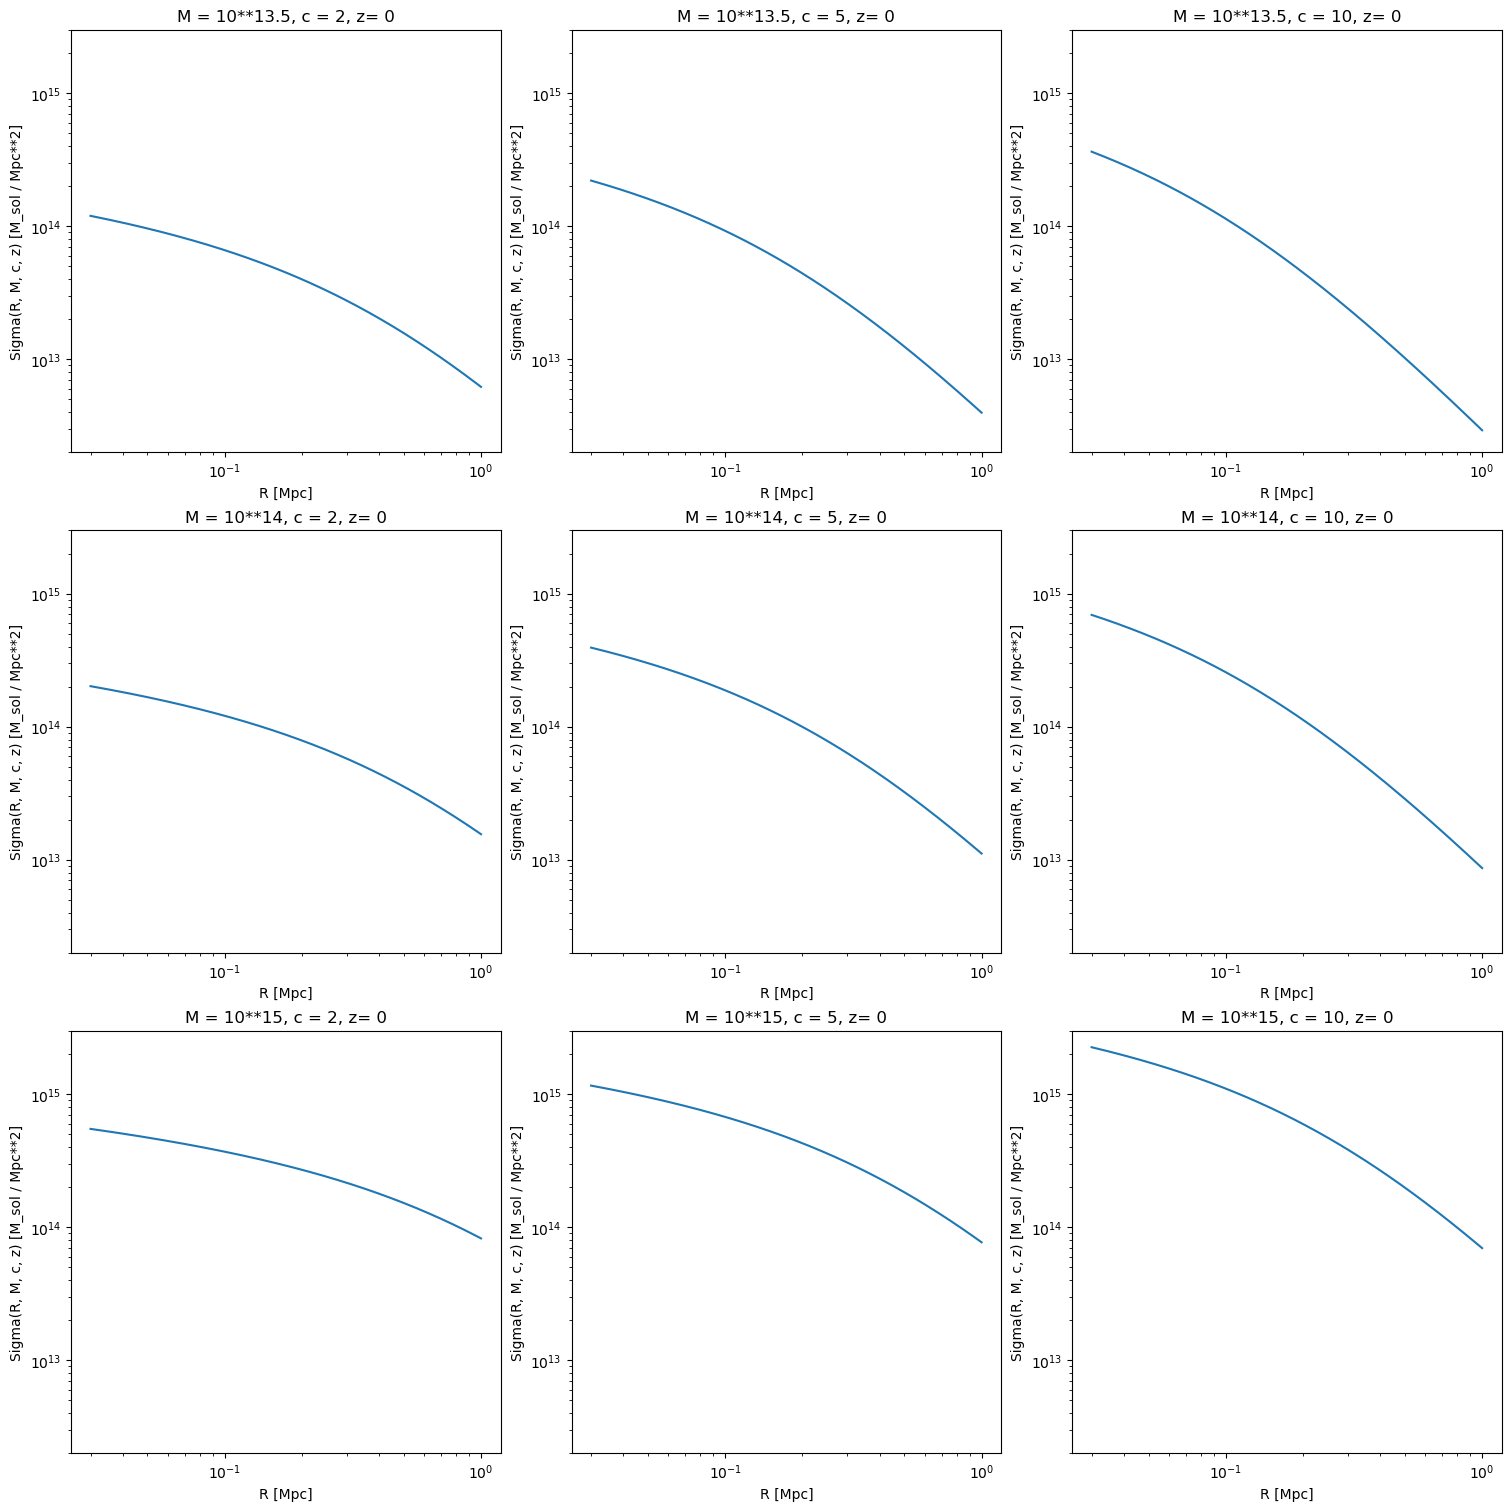

In [10]:
fig, axs = plt.subplots(3, 3, layout = 'constrained')
fig.set_size_inches(15, 15)

axs[0, 0].plot(R, Sigma[:, 0, 0])
axs[0, 0].set_title('M = 10**13.5, c = 2, z= 0')
axs[0, 1].plot(R, Sigma[:, 0, 1])
axs[0, 1].set_title('M = 10**13.5, c = 5, z= 0')
axs[0, 2].plot(R, Sigma[:, 0, 2])
axs[0, 2].set_title('M = 10**13.5, c = 10, z= 0')
axs[1, 0].plot(R, Sigma[:, 1, 0])
axs[1, 0].set_title('M = 10**14, c = 2, z= 0')
axs[1, 1].plot(R, Sigma[:, 1, 1])
axs[1, 1].set_title('M = 10**14, c = 5, z= 0')
axs[1, 2].plot(R, Sigma[:, 1, 2])
axs[1, 2].set_title('M = 10**14, c = 10, z= 0')
axs[2, 0].plot(R, Sigma[:, 2, 0])
axs[2, 0].set_title('M = 10**15, c = 2, z= 0')
axs[2, 1].plot(R, Sigma[:, 2, 1])
axs[2, 1].set_title('M = 10**15, c = 5, z= 0')
axs[2, 2].plot(R, Sigma[:, 2, 2])
axs[2, 2].set_title('M = 10**15, c = 10, z= 0')



for ax in axs.flat:
    ax.set(xlabel = 'R [Mpc]', ylabel = 'Sigma(R, M, c, z) [M_sol / Mpc**2]', xscale = 'log', yscale = 'log', ylim = [2e12, 3e15])

Importo i file con i dati

In [11]:
hdul = fits.open('halo_catalog.fits')
hdul.info()

Filename: halo_catalog.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     14   40103R x 3C   [E, E, 8E]   


Ho trovato che ci sono 2 HDU: Primary e una tabella. La tabella contiene i miei dati, perciò procedo a leggere quella.

In [12]:
data = hdul[1].data
data

FITS_rec([(0.5024944 , 290.69226 , [2.35110187e+15, 1.99265303e+15, 1.49606757e+15, 1.18663491e+15, 8.96338200e+14, 6.25385692e+14, 3.94313263e+14, 2.28581414e+14]),
          (0.6013021 , 119.24578 , [2.10765923e+15, 1.98006381e+15, 1.65222587e+15, 1.22958646e+15, 9.86441849e+14, 7.12462798e+14, 4.49373637e+14, 2.62464394e+14]),
          (0.20896086, 126.37386 , [1.81413701e+15, 1.73958698e+15, 1.34463924e+15, 1.12188935e+15, 8.70322039e+14, 5.94193290e+14, 3.66820205e+14, 1.86497462e+14]),
          ...,
          (0.62278223,   8.831167, [6.41927624e+14, 4.42689795e+14, 3.83484309e+14, 2.78102488e+14, 1.81649199e+14, 1.09778534e+14, 7.18503737e+13, 5.32619272e+13]),
          (0.5350497 ,  12.180819, [3.16326053e+14, 3.31781459e+14, 2.49146104e+14, 1.71900714e+14, 1.45082435e+14, 1.28306419e+14, 8.72312723e+13, 5.76063915e+13]),
          (0.49350488,  17.996544, [6.87486087e+14, 4.99000340e+14, 3.65499804e+14, 2.43635778e+14, 1.55504676e+14, 9.16257453e+13, 5.05067728e+13, 3.65255

In [13]:
data.columns.names

['Z', 'LAMBDA_TR', 'SIGMA_of_R']

In [14]:
SigR = data['SIGMA_of_R'].newbyteorder().byteswap() #questo è un numpyarray
np.shape(SigR)

(40103, 8)

Nota: data['SIGMA_of_R'] è già un numpyarray e in una prima versione del codice non avevo applicato la funzione .newbyteorder().byteswap(). Il problema è sorto più avanti (nell'atto di fare il groupby e calcolare la media per gli intervalli) perché mi restituiva l'errore "Big-endian buffer not supported on little-endian compiler".
A quanto pare (https://github.com/pandas-dev/pandas/issues/9989, https://github.com/astropy/astropy/issues/1156) il problema è dato dal fatto che i dati nel file .fits sono big-endian, ma Pandas lavora con dati little-endian e questo ovviamente creava problemi. La funzione .newbyteorder().byteswap() serve proprio a questo: invertire l'ordine con cui sono ordinati i byte  di un numpyarray. Applicandolo alle colonne della tabella del file .fits trasformo quei numpyarray in little-endian rendendoli a questo punto compatibili con pandas.

In [15]:
data_dict = {'Z': data['Z'].newbyteorder().byteswap(), 'LAMBDA_TR': data['LAMBDA_TR'].newbyteorder().byteswap()}
df1 = pd.DataFrame(data_dict)
df1

,Z,LAMBDA_TR
0,0.502494,290.692261
1,0.601302,119.245781
2,0.208961,126.373863
3,0.212769,188.812729
4,0.458008,147.349625
...,...,...
40098,0.479437,9.510518
40099,0.599918,17.036392
40100,0.622782,8.831167
40101,0.535050,12.180819


In [16]:
#df2 = pd.DataFrame(SigR, columns = ['SIGMA_of_R0', 'SIGMA_of_R1', 'SIGMA_of_R2', 'SIGMA_of_R3', 'SIGMA_of_R4', 'SIGMA_of_R5', 'SIGMA_of_R6', 'SIGMA_of_R7'])d
R = np.load('R_values.npy')
df2 = pd.DataFrame(SigR, columns = [R[0], R[1], R[2], R[3], R[4], R[5], R[6], R[7]])
df2

,0.040563,0.063973,0.100892,0.159117,0.250945,0.395767,0.624167,0.984378
0,2.351102e+15,1.992653e+15,1.496068e+15,1.186635e+15,8.963382e+14,6.253857e+14,3.943133e+14,2.285814e+14
1,2.107659e+15,1.980064e+15,1.652226e+15,1.229586e+15,9.864418e+14,7.124628e+14,4.493736e+14,2.624644e+14
2,1.814137e+15,1.739587e+15,1.344639e+15,1.121889e+15,8.703220e+14,5.941933e+14,3.668202e+14,1.864975e+14
3,2.349731e+15,1.945845e+15,1.539410e+15,1.077038e+15,7.059310e+14,4.613497e+14,2.969404e+14,1.913648e+14
4,2.240655e+15,1.679705e+15,1.314239e+15,1.120241e+15,8.280310e+14,5.703857e+14,3.796933e+14,2.315893e+14
...,...,...,...,...,...,...,...,...
40098,7.317734e+14,7.352522e+14,5.704476e+14,3.042415e+14,1.612240e+14,9.388085e+13,6.723513e+13,6.424537e+13
40099,5.234640e+14,4.248873e+14,3.092860e+14,2.059087e+14,1.372936e+14,8.645296e+13,4.359242e+13,2.579911e+13
40100,6.419276e+14,4.426898e+14,3.834843e+14,2.781025e+14,1.816492e+14,1.097785e+14,7.185037e+13,5.326193e+13
40101,3.163261e+14,3.317815e+14,2.491461e+14,1.719007e+14,1.450824e+14,1.283064e+14,8.723127e+13,5.760639e+13


In [17]:
df = pd.concat([df1, df2], axis=1)
df

,Z,LAMBDA_TR,0.040563287600710346,0.06397265799644548,0.10089174751847561,0.15911711403170734,0.25094476605376465,0.39576682868462515,0.624166764464525,0.9843779761859772
0,0.502494,290.692261,2.351102e+15,1.992653e+15,1.496068e+15,1.186635e+15,8.963382e+14,6.253857e+14,3.943133e+14,2.285814e+14
1,0.601302,119.245781,2.107659e+15,1.980064e+15,1.652226e+15,1.229586e+15,9.864418e+14,7.124628e+14,4.493736e+14,2.624644e+14
2,0.208961,126.373863,1.814137e+15,1.739587e+15,1.344639e+15,1.121889e+15,8.703220e+14,5.941933e+14,3.668202e+14,1.864975e+14
3,0.212769,188.812729,2.349731e+15,1.945845e+15,1.539410e+15,1.077038e+15,7.059310e+14,4.613497e+14,2.969404e+14,1.913648e+14
4,0.458008,147.349625,2.240655e+15,1.679705e+15,1.314239e+15,1.120241e+15,8.280310e+14,5.703857e+14,3.796933e+14,2.315893e+14
...,...,...,...,...,...,...,...,...,...,...
40098,0.479437,9.510518,7.317734e+14,7.352522e+14,5.704476e+14,3.042415e+14,1.612240e+14,9.388085e+13,6.723513e+13,6.424537e+13
40099,0.599918,17.036392,5.234640e+14,4.248873e+14,3.092860e+14,2.059087e+14,1.372936e+14,8.645296e+13,4.359242e+13,2.579911e+13
40100,0.622782,8.831167,6.419276e+14,4.426898e+14,3.834843e+14,2.781025e+14,1.816492e+14,1.097785e+14,7.185037e+13,5.326193e+13
40101,0.535050,12.180819,3.163261e+14,3.317815e+14,2.491461e+14,1.719007e+14,1.450824e+14,1.283064e+14,8.723127e+13,5.760639e+13


In [18]:
int_mean = df.groupby(pd.cut(df['LAMBDA_TR'], [15, 20, 30, 45, 60, 200])).mean()
int_mean

,Z,LAMBDA_TR,0.040563287600710346,0.06397265799644548,0.10089174751847561,0.15911711403170734,0.25094476605376465,0.39576682868462515,0.624166764464525,0.9843779761859772
LAMBDA_TR,,,,,,,,,,
"(15, 20]",0.460090,17.523481,6.040370e+14,4.900458e+14,3.598957e+14,2.441868e+14,1.573150e+14,9.940772e+13,6.326566e+13,4.258762e+13
"(20, 30]",0.463887,24.182133,6.717476e+14,5.498711e+14,4.078379e+14,2.780886e+14,1.798401e+14,1.131488e+14,7.073311e+13,4.623129e+13
"(30, 45]",0.459208,35.880253,8.322382e+14,6.875067e+14,5.164361e+14,3.578354e+14,2.345928e+14,1.480616e+14,9.084872e+13,5.603594e+13
"(45, 60]",0.456439,51.205067,1.017487e+15,8.481862e+14,6.493962e+14,4.575311e+14,3.030807e+14,1.918116e+14,1.166462e+14,6.985587e+13
"(60, 200]",0.441161,78.995392,1.299284e+15,1.092726e+15,8.503404e+14,6.101899e+14,4.143562e+14,2.673323e+14,1.639046e+14,9.581197e+13


In [304]:
#R_int_mean = int_mean.loc[:, ['SIGMA_of_R0', 'SIGMA_of_R1', 'SIGMA_of_R2', 'SIGMA_of_R3', 'SIGMA_of_R4', 'SIGMA_of_R5', 'SIGMA_of_R6', 'SIGMA_of_R7']]
R_int_mean = int_mean.loc[:, [R[0], R[1], R[2], R[3], R[4], R[5], R[6], R[7]]]
R_int_mean

,0.040563287600710346,0.06397265799644548,0.10089174751847561,0.15911711403170734,0.25094476605376465,0.39576682868462515,0.624166764464525,0.9843779761859772
LAMBDA_TR,,,,,,,,
"(15, 20]",6.040370e+14,4.900458e+14,3.598957e+14,2.441868e+14,1.573150e+14,9.940772e+13,6.326566e+13,4.258762e+13
"(20, 30]",6.717476e+14,5.498711e+14,4.078379e+14,2.780886e+14,1.798401e+14,1.131488e+14,7.073311e+13,4.623129e+13
"(30, 45]",8.322382e+14,6.875067e+14,5.164361e+14,3.578354e+14,2.345928e+14,1.480616e+14,9.084872e+13,5.603594e+13
"(45, 60]",1.017487e+15,8.481862e+14,6.493962e+14,4.575311e+14,3.030807e+14,1.918116e+14,1.166462e+14,6.985587e+13
"(60, 200]",1.299284e+15,1.092726e+15,8.503404e+14,6.101899e+14,4.143562e+14,2.673323e+14,1.639046e+14,9.581197e+13


In [20]:
np.shape(R_int_mean.T.to_numpy())

(8, 5)

In [21]:
int_std = df.groupby(pd.cut(df['LAMBDA_TR'], [15, 20, 30, 45, 60, 200])).std()
int_std

,Z,LAMBDA_TR,0.040563287600710346,0.06397265799644548,0.10089174751847561,0.15911711403170734,0.25094476605376465,0.39576682868462515,0.624166764464525,0.9843779761859772
LAMBDA_TR,,,,,,,,,,
"(15, 20]",0.123092,1.431712,2.640365e+14,1.893752e+14,1.290308e+14,8.427349e+13,5.494038e+13,3.674195e+13,2.582108e+13,1.894787e+13
"(20, 30]",0.121813,2.802659,2.909992e+14,2.158597e+14,1.503459e+14,9.890763e+13,6.334698e+13,4.086933e+13,2.733401e+13,1.925362e+13
"(30, 45]",0.123646,4.126287,3.577725e+14,2.718182e+14,1.921912e+14,1.287568e+14,8.286741e+13,5.236009e+13,3.307377e+13,2.167616e+13
"(45, 60]",0.123037,4.253189,4.315102e+14,3.348032e+14,2.392007e+14,1.605941e+14,1.020653e+14,6.255899e+13,3.837411e+13,2.473522e+13
"(60, 200]",0.122742,20.190181,5.590717e+14,4.439427e+14,3.350374e+14,2.319237e+14,1.544334e+14,9.987915e+13,6.196603e+13,3.787068e+13


In [327]:
#R_int_std = int_std.loc[:, ['SIGMA_of_R0', 'SIGMA_of_R1', 'SIGMA_of_R2', 'SIGMA_of_R3', 'SIGMA_of_R4', 'SIGMA_of_R5', 'SIGMA_of_R6', 'SIGMA_of_R7']]
R_int_std = int_std.loc[:, [R[0], R[1], R[2], R[3], R[4], R[5], R[6], R[7]]]
R_int_std


,0.040563287600710346,0.06397265799644548,0.10089174751847561,0.15911711403170734,0.25094476605376465,0.39576682868462515,0.624166764464525,0.9843779761859772
LAMBDA_TR,,,,,,,,
"(15, 20]",2.640365e+14,1.893752e+14,1.290308e+14,8.427349e+13,5.494038e+13,3.674195e+13,2.582108e+13,1.894787e+13
"(20, 30]",2.909992e+14,2.158597e+14,1.503459e+14,9.890763e+13,6.334698e+13,4.086933e+13,2.733401e+13,1.925362e+13
"(30, 45]",3.577725e+14,2.718182e+14,1.921912e+14,1.287568e+14,8.286741e+13,5.236009e+13,3.307377e+13,2.167616e+13
"(45, 60]",4.315102e+14,3.348032e+14,2.392007e+14,1.605941e+14,1.020653e+14,6.255899e+13,3.837411e+13,2.473522e+13
"(60, 200]",5.590717e+14,4.439427e+14,3.350374e+14,2.319237e+14,1.544334e+14,9.987915e+13,6.196603e+13,3.787068e+13


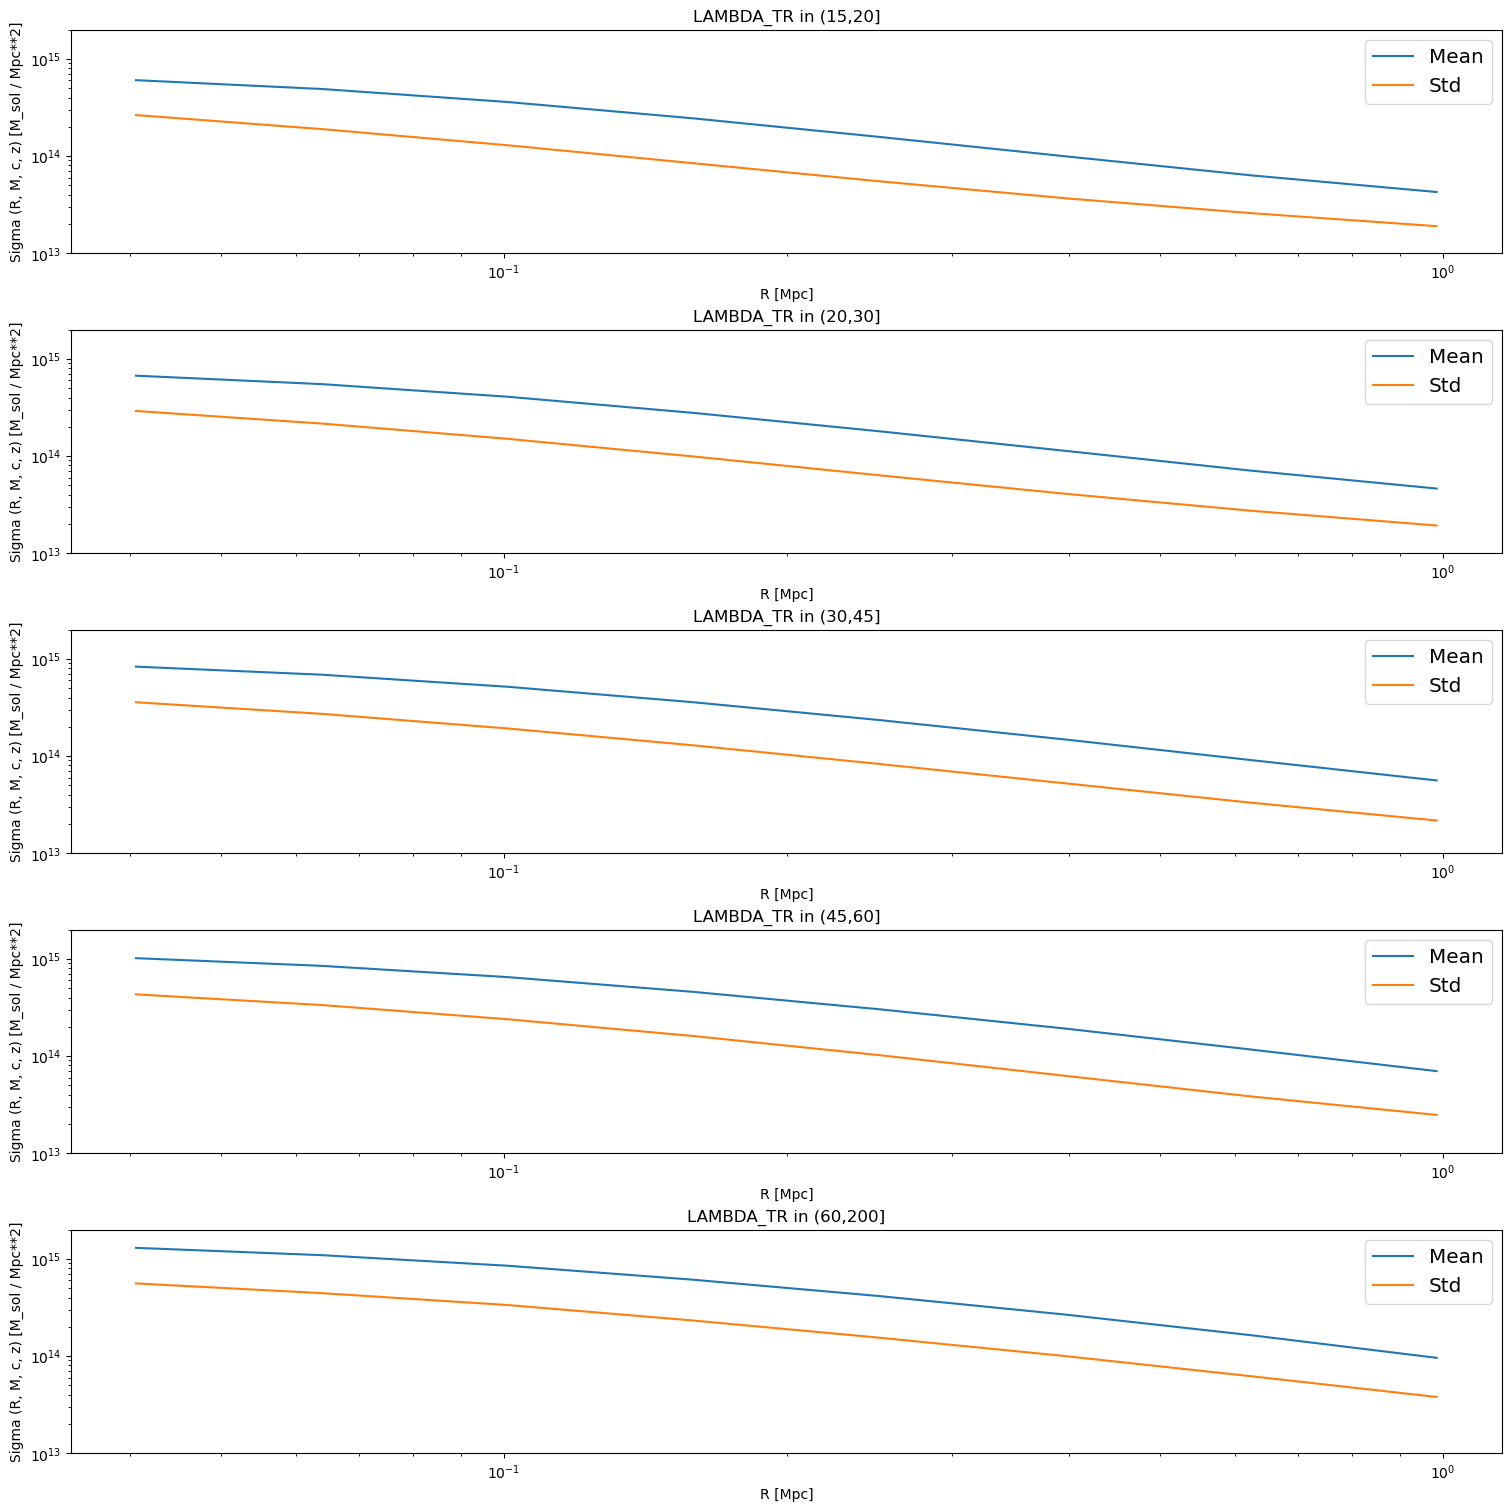

In [23]:
fig, axs = plt.subplots(5, layout = 'constrained')
fig.set_size_inches(15, 15)

axs[0].plot(R, R_int_mean.T.to_numpy()[:,0], label = 'Mean')
axs[0].set_title('LAMBDA_TR in (15,20]')
axs[0].plot(R, R_int_std.T.to_numpy()[:,0], color = 'tab:orange', label = 'Std')
axs[0].legend(fontsize = 'x-large')
axs[1].plot(R, R_int_mean.T.to_numpy()[:,1], label = 'Mean')
axs[1].set_title('LAMBDA_TR in (20,30]')
axs[1].plot(R, R_int_std.T.to_numpy()[:,1], color = 'tab:orange', label = 'Std')
axs[2].plot(R, R_int_mean.T.to_numpy()[:,2], label = 'Mean')
axs[2].set_title('LAMBDA_TR in (30,45]')
axs[2].plot(R, R_int_std.T.to_numpy()[:,2], color = 'tab:orange', label = 'Std')
axs[3].plot(R, R_int_mean.T.to_numpy()[:,3], label = 'Mean')
axs[3].set_title('LAMBDA_TR in (45,60]')
axs[3].plot(R, R_int_std.T.to_numpy()[:,3], color = 'tab:orange', label = 'Std')
axs[4].plot(R, R_int_mean.T.to_numpy()[:,4], label = 'Mean')
axs[4].set_title('LAMBDA_TR in (60,200]')
axs[4].plot(R, R_int_std.T.to_numpy()[:,4], color = 'tab:orange', label = 'Std')

for ax in axs.flat:
    ax.set(xlabel = 'R [Mpc]', ylabel = 'Sigma (R, M, c, z) [M_sol / Mpc**2]', xscale = 'log', yscale = 'log', ylim = [1e13, 2e15])
    ax.legend(fontsize = 'x-large')

I parametri che devo inferire sono Log(M) e c.
Devo assumere una likelihood gaussiana, con matrici di covarianza date da Sigma-cov.npy.
Devo utilizzare la Sigma.
I prior sono Log(M) tra 13 e 16, c tra 0.2 e 20.
Lo devo fare per ogni bin di ricchezza e devo utilizzare il relativo redshift medio.

In [306]:
CovMat = np.load('covariance_matrices.npy')
rho_m = 0.286 * 0.7**2 *2.7751428946e11

R = np.load('R_values.npy')
Sigma_R = R_int_mean.to_numpy()
z_int_mean = int_mean.loc[:, ['Z']]
z = np.squeeze(z_int_mean.to_numpy())
Sigma_R[0], z[0].shape

(array([6.0403702e+14, 4.9004580e+14, 3.5989568e+14, 2.4418683e+14,
        1.5731502e+14, 9.9407723e+13, 6.3265661e+13, 4.2587625e+13],
       dtype=float32),
 ())

Nota: Ho dovuto usare np.squeeze perché il redshift veniva passato come array (5,1) invece che come array (5,), questo dava problemi con il minimize dato che tutte le funzioni che ricevevano z[i] come input non restituivano un float come output, ma un array (1,) con cui minimize non sapeva lavorare.

In [118]:
def r_s(lM, c, rdsft_i):
    return np.cbrt(3 * 10**lM / (4 * np.pi * 200 * rho_m * (1 + rdsft_i)**3)) / c

def rho_s(c, rdsft_i):
    f_c = np.log(1 + c) - c / (1 + c)
    delta_char = 200 * c**3 / (3 * f_c)
    return rho_m * (1 + rdsft_i)**3 * delta_char
    
def f(x):
    f = np.empty(8)
    for j in range(8):
        if np.less(x, np.ones(8))[j]:
            f[j] = (1 - (2 * np.arctanh(np.sqrt((1-x[j])/(1+x[j]))) / np.sqrt(1 - x[j]**2))) / (x[j]**2 - 1)
        elif np.greater(x, np.ones(8))[j]:
            f[j] = (1 - (2 * np.arctan(np.sqrt((x[j]-1)/(1+x[j]))) / np.sqrt(x[j]**2 - 1))) / (x[j]**2 - 1)
        else: 
            f[j] = 1./3
    return f

def Sigma(Rad, lM, c, rdsft_i):
    x = Rad / r_s(lM, c, rdsft_i)
    return 2 * r_s(lM, c, rdsft_i) * rho_s(c, rdsft_i) * f(x)

In [288]:
def log_prior(param):
    lM, c = param
    if (13 < lM < 16 and 0.2 < c < 20):
        return 0.0
    return -np.inf

def log_likelihood(param, Denprof, Rad, rdsft, TCOV):
    lM, c = param
    
    th_Sigma = Sigma(Rad, lM, c, rdsft)
    
    iTCOV = np.linalg.inv(TCOV)
    
    residuals = (Denprof - th_Sigma).T
    
    p, _ = TCOV.shape
    lognormalization = - 0.5 * (p * np.log(2 * np.pi) + np.log(np.linalg.det(TCOV)))
    exponent = -0.5 * np.sum(residuals @ iTCOV * residuals)
    return np.nansum(lognormalization + exponent)

def log_posterior(param, Denprof, Rad, rdsft, TCOV):
    lp = -log_prior(param)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(param, Denprof, Rad, rdsft, TCOV)

In [289]:
lM = 14.53
c = 10.09

param = [lM, c]
lint, _, _ = CovMat.shape
for k in range(lint):
    print(log_likelihood(param, Sigma_R[k], R, z[k], CovMat[k]))

-307.75716555362806
-291.25287843490526
-276.1808919815963
-272.61597568279973
-274.43994324158535


In [314]:
nll = lambda *args: -log_posterior(*args)
initial = np.array([13 + 3 * np.random.rand(), 0.2 + 19.8 * np.random.rand()]) 
soln0 = minimize(nll, initial, args = (Sigma_R[0], R, z[0], CovMat[0]))
soln = [soln0, soln0, soln0, soln0, soln0]
print(initial, soln0.x, log_likelihood(soln0.x, Sigma_R[0], R, z[0], CovMat[0]))
for k in range(lint - 1):
    soln[k + 1] = minimize(nll, initial, args = (Sigma_R[k + 1], R, z[k + 1], CovMat[k + 1]))
    print(initial, soln[k + 1].x, log_likelihood(soln[k + 1].x, Sigma_R[k + 1], R, z[k + 1], CovMat[k + 1]))

[15.56986844  8.08645887] [14.33028379  2.67712071] -261.57026998461356
[15.56986844  8.08645887] [14.40885261  2.79773417] -262.4791011391313
[15.56986844  8.08645887] [14.56837283  3.06710759] -264.1100686888805
[15.56986844  8.08645887] [14.72062508  3.31349763] -265.40322625338666
[15.56986844  8.08645887] [14.92337943  3.57161428] -268.57994727410323


C:\Users\Ghigu\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Ghigu\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Ghigu\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [317]:
residui = (Sigma_R[0] - Sigma(R, soln0.x[0], soln0.x[1], z[0])).T
np.sum(residui @ np.linalg.inv(CovMat[0]) * residui)
#np.nansum(-0.5 * np.sum(residui @ np.linalg.inv(CovMat[0]) * residui) + (- 0.5 * (8 * np.log(2 * np.pi) + np.log(np.linalg.det(CovMat[0])))))

0.5707701469567849

In [218]:
nparams = len(param)

pos = soln[0].x * (1+1e-4 * np.random.randn(32,nparams ))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args = (Sigma_R[0], R, z[0], CovMat[0])
)
sampler.run_mcmc(pos, 2000, progress=True);

100%|██████████| 2000/2000 [00:08<00:00, 223.79it/s]


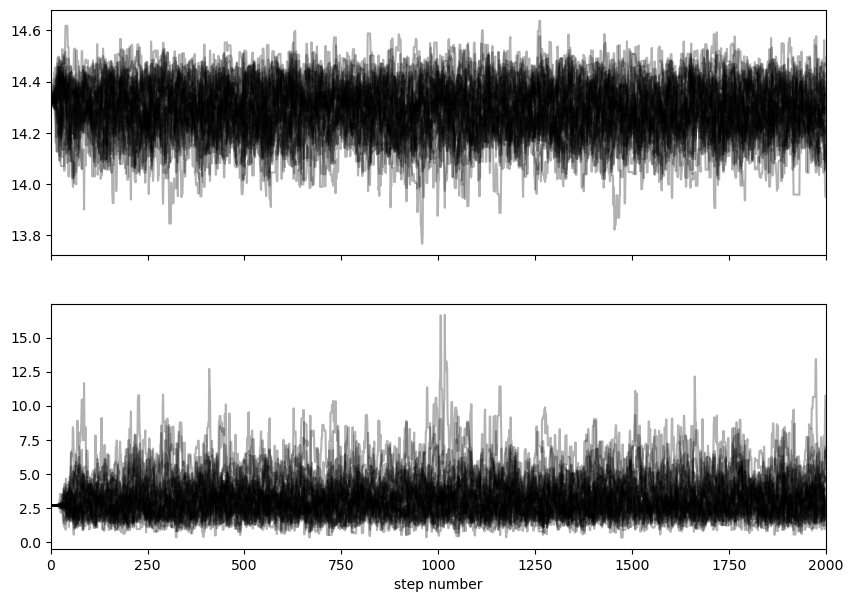

In [219]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [220]:
print(sampler.get_autocorr_time())

[28.16887398 29.26971399]


In [221]:
flat_samples = sampler.get_chain(discard = 100, flat = True)
flat_samples.shape

(60800, 2)

In [222]:
bf_lM = np.median(flat_samples[:, 0])
bf_c = np.median(flat_samples[:, 1])

print('Best-fit log_10(M) =', bf_lM)
print('Best-fit c =', bf_c)
print('Mean log_10(M) =', flat_samples[:,0].mean())
print('Mean c =', flat_samples[:,1].mean())
print('std log_10(M) =', flat_samples[:,0].std())
print('std c =', flat_samples[:,1].std())

Best-fit log_10(M) = 14.295394482079397
Best-fit c = 2.985967478021095
Mean log_10(M) = 14.290947826297856
Mean c = 3.186824486691814
std log_10(M) = 0.09880881787922223
std c = 1.3458888420199742


In [223]:
bf_param = [bf_lM, bf_c]
log_likelihood(bf_param, Sigma_R[0], R, z[0], CovMat[0])

-261.64359160901137

In [330]:
x_i = Sigma_R[0]
mu_i = Sigma(R, bf_lM, bf_c, z[0])
#mu_i = Sigma(R, soln0.x[0], soln0.x[1], z[0])
var_i = np.empty(8)

for i in range(8):
    var_i[i] = CovMat[0, i, i]

t = np.sum((x_i - mu_i)**2 / var_i)
t

0.717413395752348

[6.96916606e-01 4.93073599e-01 5.04640191e+00 7.45138611e+00
 3.91763635e+00 7.59423670e-01 1.11870825e+00 5.19866603e-01
 4.27525200e+00 5.66980819e+00 2.30325948e-01 3.29575736e+00
 8.51273380e+00 1.95426416e+00 1.02694837e+01 2.27172893e+00
 1.71597631e+00 2.61686854e+00 8.03936032e-02 1.76966763e+00
 2.11838837e+00 1.20395386e+00 1.40369428e+01 1.92806088e-01
 4.53076913e-01 2.35637797e+00 1.49284704e+00 6.73580664e-01
 9.44743063e-03 5.86168639e-01 1.39213783e+00 8.30649579e-01
 1.12226577e+00 1.03065659e+00 2.56622192e+00 4.18012219e+00
 1.94165262e+00 3.81132464e+00 4.62643004e+00 3.46819224e+00
 9.67913662e+00 1.60641447e+00 3.94825881e-01 6.03011576e+00
 1.72535284e+01 1.31995441e-01 1.01438802e+00 1.25553577e+00
 3.01575500e+00 2.96904401e-01 6.68639281e-01 4.23810376e-02
 1.08810379e+01 3.66333051e+00 3.32402326e+00 1.68218524e+00
 5.76511061e+00 5.01766547e+00 1.36265652e-01 4.55673606e-01
 3.24875357e+00 3.72419234e-01 4.73253192e+00 6.42397770e+00
 1.07201855e+00 4.411850

(array([0.25052074, 0.10670328, 0.05567128, 0.01391782, 0.00927855,
        0.00927855, 0.00927855, 0.00927855]),
 array([9.44743063e-03, 2.16495755e+00, 4.32046766e+00, 6.47597778e+00,
        8.63148790e+00, 1.07869980e+01, 1.29425081e+01, 1.50980182e+01,
        1.72535284e+01]),
 <BarContainer object of 8 artists>)

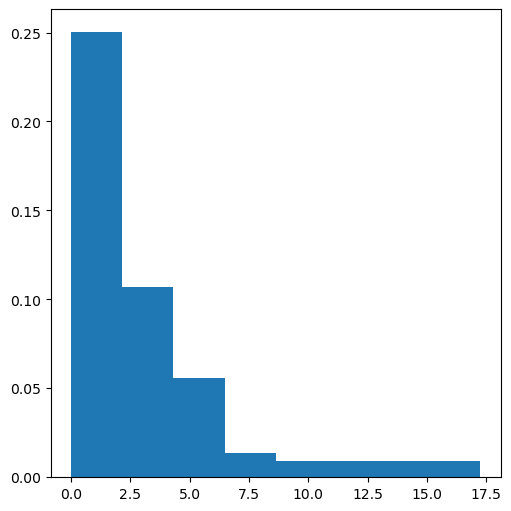

In [481]:
from scipy.stats import chi2

rdn_values = np.empty([100, 2])
for i in range(2):
    for j in range(100):
        rdn_values[j, i] = flat_samples[np.random.randint(0, flat_samples.shape[0]), i]

t_rdn = np.empty(100)        

for j in range(100):
    mu_i = Sigma(R, rdn_values[j, 0], rdn_values[j, 1], z[0])
    t_rdn[j] = np.sum((x_i - mu_i)**2 / var_i)
    
print(t_rdn)

fig, ax = plt.subplots(1, layout = 'constrained')
fig.set_size_inches(5,5)

ax.hist(t_rdn, bins = 'sturges', density = 'True')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


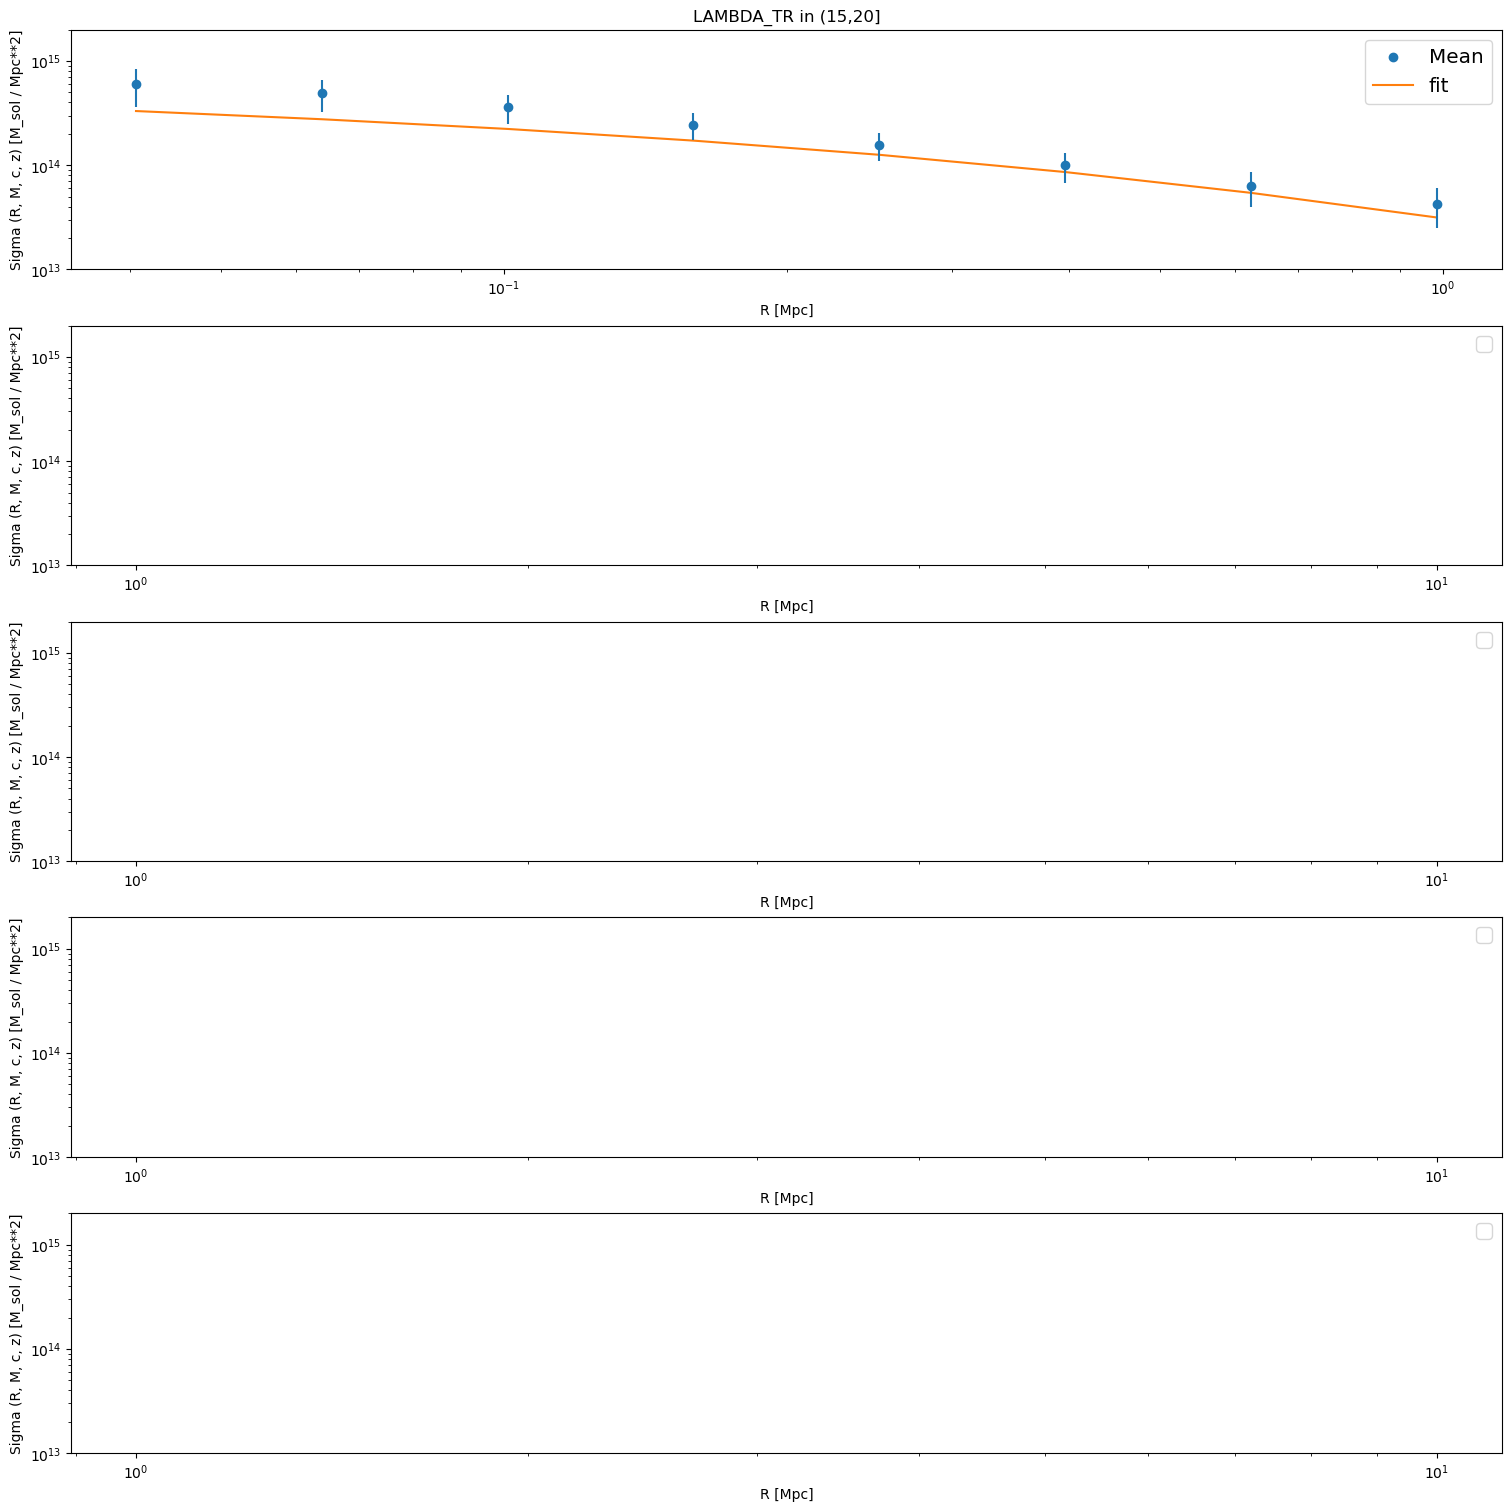

In [470]:
fig, axs = plt.subplots(5, layout = 'constrained')
fig.set_size_inches(15, 15)

axs[0].scatter(R, R_int_mean.T.to_numpy()[:,0], label = 'Mean')
axs[0].set_title('LAMBDA_TR in (15,20]')
axs[0].plot(R, Sigma(R, rdn_values[99, 0], rdn_values[99, 1], z[0]), color = 'tab:orange', label = 'fit')
axs[0].errorbar(R, R_int_mean.T.to_numpy()[:,0], np.sqrt(var_i), fmt='none')
axs[0].legend(fontsize = 'x-large')

for ax in axs.flat:
    ax.set(xlabel = 'R [Mpc]', ylabel = 'Sigma (R, M, c, z) [M_sol / Mpc**2]', xscale = 'log', yscale = 'log', ylim = [1e13, 2e15])
    ax.legend(fontsize = 'x-large')

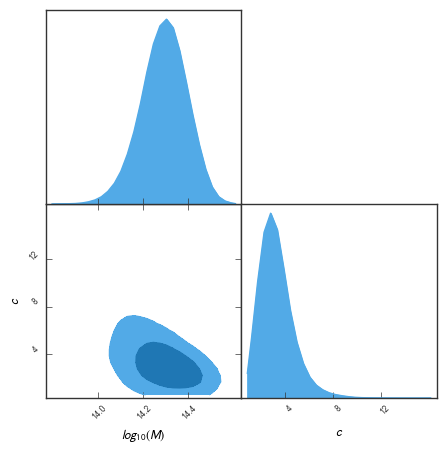

In [409]:
GTC = pygtc.plotGTC(chains=flat_samples,
                    paramNames=['$log_{10}(M)$','$c$'],
                    figureSize='MNRAS_page')

Voglio che bf_Sigma sia una matrice in cui nelle righe vario il valore di z e nelle colonne quello di R. (Matrice 40103x8)

In [326]:
df_15 = df[15 < df['LAMBDA_TR']]
df_1520 = df_15[20 >= df_15['LAMBDA_TR']]

df_20 = df[20 < df['LAMBDA_TR']]
df_2030 = df_15[30 >= df_15['LAMBDA_TR']]

df_30 = df[30 < df['LAMBDA_TR']]
df_3045 = df_15[45 >= df_15['LAMBDA_TR']]

df_45 = df[45 < df['LAMBDA_TR']]
df_4560 = df_15[60 >= df_15['LAMBDA_TR']]

df_60 = df[60 < df['LAMBDA_TR']]
df_60200 = df_15[200 >= df_15['LAMBDA_TR']]

df_1520

,Z,LAMBDA_TR,0.040563287600710346,0.06397265799644548,0.10089174751847561,0.15911711403170734,0.25094476605376465,0.39576682868462515,0.624166764464525,0.9843779761859772
610,0.252783,17.650555,1.213777e+15,1.030156e+15,7.102931e+14,5.172830e+14,3.498936e+14,2.185120e+14,1.306555e+14,7.857157e+13
1822,0.446073,19.941235,1.000903e+15,7.430157e+14,5.726096e+14,4.088594e+14,2.896388e+14,1.800644e+14,1.051909e+14,7.525190e+13
1874,0.522563,19.262348,1.241843e+15,1.104036e+15,8.577291e+14,5.527825e+14,3.398604e+14,2.024603e+14,1.092407e+14,6.265059e+13
1894,0.547292,18.698738,9.810747e+14,7.136635e+14,5.541071e+14,4.334603e+14,3.255994e+14,2.350101e+14,1.400914e+14,8.299623e+13
1908,0.310029,18.493238,8.375443e+14,6.495523e+14,4.827010e+14,3.786104e+14,2.545990e+14,1.616252e+14,1.095899e+14,7.658654e+13
...,...,...,...,...,...,...,...,...,...,...
40088,0.443909,18.843332,3.321331e+14,3.054613e+14,2.204555e+14,1.598557e+14,1.204629e+14,7.520811e+13,4.198240e+13,2.433819e+13
40092,0.404278,16.030588,5.283792e+14,5.289313e+14,3.383153e+14,2.096839e+14,1.294770e+14,8.296920e+13,5.195827e+13,3.255986e+13
40096,0.542068,18.152740,4.327046e+14,3.318594e+14,2.137572e+14,1.787193e+14,1.327765e+14,9.296434e+13,6.444705e+13,3.767180e+13
40099,0.599918,17.036392,5.234640e+14,4.248873e+14,3.092860e+14,2.059087e+14,1.372936e+14,8.645296e+13,4.359242e+13,2.579911e+13


In [228]:
rho_m = 0.286 * 0.7**2 *2.7751428946e11
z_data_1520 = df_1520['Z'].to_numpy()
z_data_1520.shape

(10185,)

In [229]:
def Sigma_1(Rad, lM, conc, rdsft):
    M = 10**lM
    
    r_s = np.cbrt(3 * M / (4 * np.pi * 200 * rho_m * (1 + rdsft)**3)) / conc
    
    f_c = np.log(1 + conc) - conc / (1 + conc)
    delta_char = 200 * conc**3 / (3 * f_c)
    rho_s = rho_m * (1 + rdsft)**3 * delta_char
    
    x = np.multiply.outer(1/r_s, Rad)

    f1 = (1 - (2 * np.arctanh(np.sqrt((1 - x) / (1 + x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
    f2 = (1 - (2 * np.arctan(np.sqrt((x - 1) / (1 + x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)
    f1[np.isnan(f1)] = 0
    f2[np.isnan(f2)] = 0
    f = f1 + f2
    f = np.where(f == 0., 1./3, f)
    
    Sigma = np.empty([rdsft.shape[0], 8])
    for i in range(8):
        Sigma[:, i] = 2* rho_s * r_s * f[:,0]
        
    return Sigma

Sigma_1(R, bf_lM, bf_c, z_data_1520).shape

C:\Users\Ghigu\AppData\Local\Temp\ipykernel_9348\1923468422.py:12: RuntimeWarning: invalid value encountered in sqrt
  f1 = (1 - (2 * np.arctanh(np.sqrt((1 - x) / (1 + x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
C:\Users\Ghigu\AppData\Local\Temp\ipykernel_9348\1923468422.py:13: RuntimeWarning: invalid value encountered in sqrt
  f2 = (1 - (2 * np.arctan(np.sqrt((x - 1) / (1 + x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)


(10185, 8)

In [37]:
nparams = len(param)

pos = soln[1].x * (1+1e-4 * np.random.randn(32,nparams ))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args = (Sigma_R[1], R, z[1], CovMat[1])
)
sampler.run_mcmc(pos, 2000, progress=True);

100%|██████████| 2000/2000 [00:09<00:00, 208.82it/s]


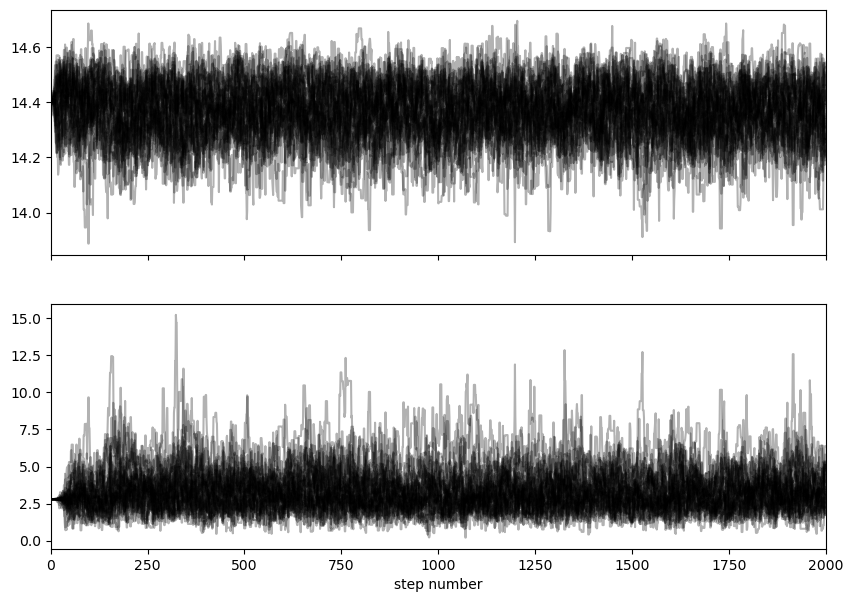

In [38]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [39]:
nparams = len(param)

pos = soln[2].x * (1+1e-4 * np.random.randn(32,nparams ))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args = (Sigma_R[2], R, z[2], CovMat[2])
)
sampler.run_mcmc(pos, 2000, progress=True);

100%|██████████| 2000/2000 [00:09<00:00, 216.48it/s]


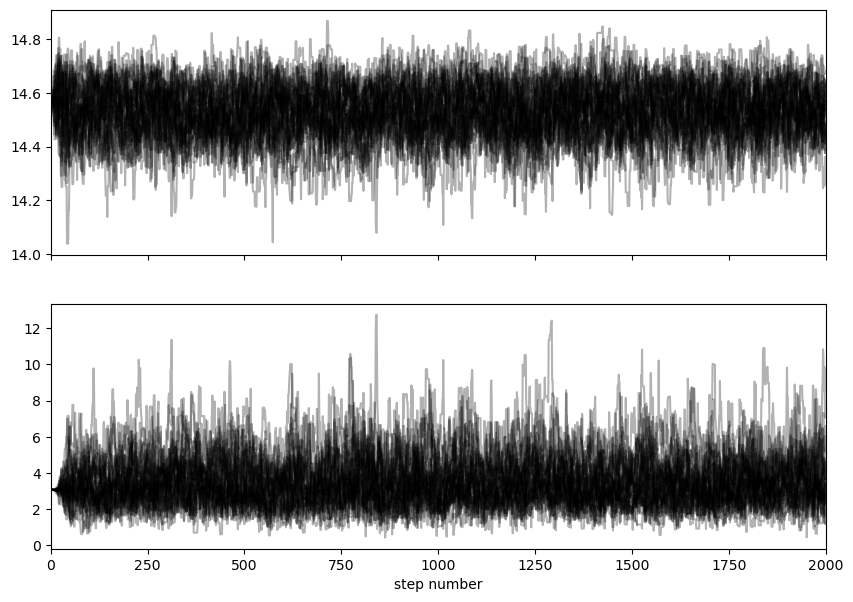

In [40]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [41]:
nparams = len(param)

pos = soln[3].x * (1+1e-4 * np.random.randn(32,nparams ))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args = (Sigma_R[3], R, z[3], CovMat[3])
)
sampler.run_mcmc(pos, 2000, progress=True);

100%|██████████| 2000/2000 [00:09<00:00, 201.66it/s]


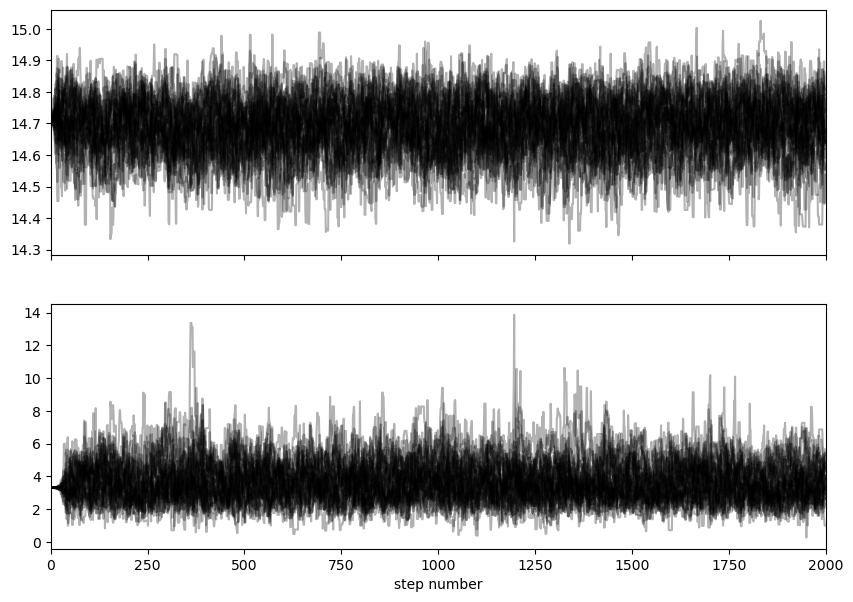

In [42]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [43]:
nparams = len(param)

pos = soln[4].x * (1+1e-4 * np.random.randn(32,nparams ))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args = (Sigma_R[4], R, z[4], CovMat[4])
)
sampler.run_mcmc(pos, 2000, progress=True);

100%|██████████| 2000/2000 [00:09<00:00, 201.49it/s]


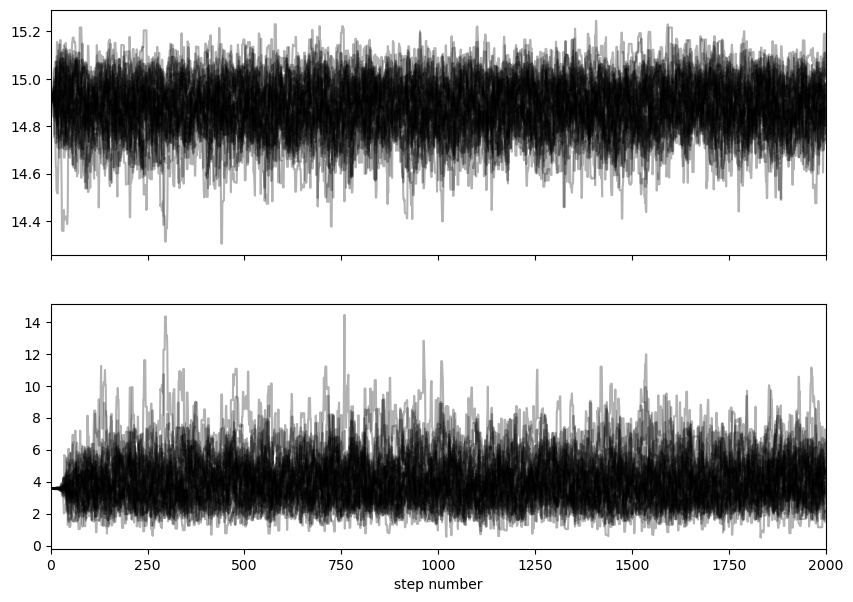

In [44]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");